# **Modeling - Data Split**

In [ ]:
#Models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_poisson_deviance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/IBE/4th Semester/Master Thesis/Codes/Data/frenchclaim_prep.csv")   #data prepared

In [ ]:
df.head()

,Unnamed: 0,Freq,VehPower,VehAge,VehBrand,VehGas,DrivAge,logDensity,PolicyRegion,group_id
0,0,10.000000,5,0,12,1,55,7.104144,82,1
1,1,1.298701,5,0,12,1,55,7.104144,82,1
2,2,1.333333,6,2,12,0,52,3.988984,22,2
3,3,11.111111,7,0,12,0,46,4.330733,72,3
4,4,1.190476,7,0,12,0,46,4.330733,72,3


In [ ]:
# Define response name and features names
#Exposure and ClaimNb are not included in the model as it is part of the calculation of Freq

#Freq is the response variable, group_id used only in terms of split
y, x = df.columns[1], list(df.loc[:, ~df.columns.isin(['Freq', 'group_id', 'Unnamed: 0'])])

print("The response name:", y)
print("The feature names:", x)

The response name: Freq
The feature names: ['VehPower', 'VehAge', 'VehBrand', 'VehGas', 'DrivAge', 'logDensity', 'PolicyRegion']


In [ ]:
# split the data into 80% training and 20% test

# Stratified split by group_id to minimize bias
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7)
split = splitter.split(df, groups=df['group_id'])
train_inds, test_inds = next(split)

train = df.iloc[train_inds]
test = df.iloc[test_inds]

# **Generalized linear model (GLM)**

Additive linear Poisson regression model

In [ ]:
!pip install glum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 31.5 MB/s eta 0:00:00


In [ ]:
from glum import GeneralizedLinearRegressor

glm_model = GeneralizedLinearRegressor(family="poisson", alpha=1e-6)
glm_fit = glm_model.fit(X=train[x], y=train[y])

print("Coefficients")
pd.Series(np.append(glm_model.intercept_, glm_model.coef_), index=["Intercept"] + x)

Coefficients


,0
Intercept,-1.560558
VehPower,-0.020055
VehAge,-0.054375
VehBrand,0.038602
VehGas,0.337124
DrivAge,-0.007764
logDensity,0.029549
PolicyRegion,-0.000925


In [ ]:
# Prediction
y_pred = glm_fit.predict(test[x])

In [ ]:
#Mean Poisson deviance regression loss.
#out-of-sample on the test data set
deviance = mean_poisson_deviance(test[y], y_pred)
print(f"Mean Poisson Deviance: {deviance:.4f}")

Mean Poisson Deviance: 1.1079


In [ ]:
#mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test[y], y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 1.2389


#**SHAP** **analysis**

Select explanation data

In [ ]:
X_explain = train[x].sample(n=1000, random_state=937)
print("Shape of X_explain:", X_explain.shape)

Shape of X_explain: (1000, 7)


# **Generalized Linear model with Kernel SHAP**

In [ ]:
!pip install shap
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
# Background data (same for the GLM, the neural net, and the true model)
X_bg = train[x].sample(200, random_state=8366)

# Subset
nsamples = 2 ** len(x) - 2

In [ ]:
# Kernel Explainer
glm_explainer = shap.KernelExplainer(lambda x: np.log(glm_model.predict(x)), data=X_bg)
shap_glm = glm_explainer.shap_values(X_explain, nsamples=nsamples)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

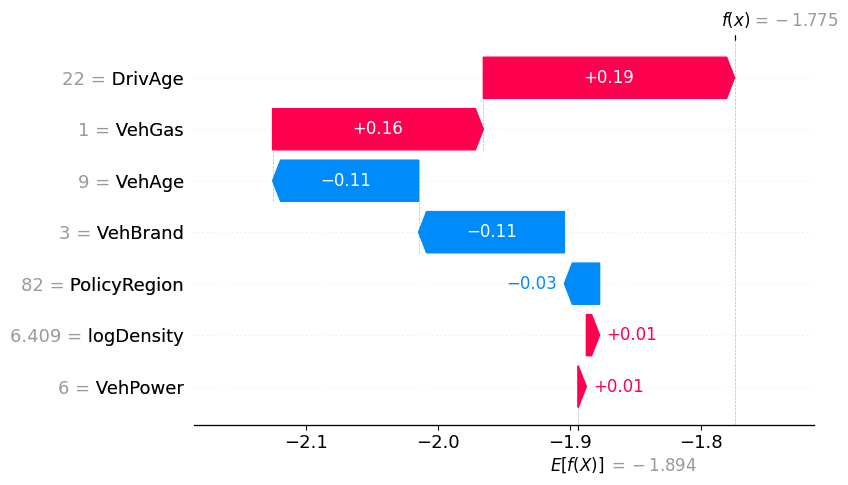

In [ ]:
# waterfall plot
# Compute SHAP values for a single instance
shap_values_glm = glm_explainer.shap_values(X_explain.iloc[0:1]) # Use .iloc to access row by position

# Plot the waterfall plot for the first instance
shap.plots.waterfall(shap.Explanation(values=shap_values_glm[0],
                                       base_values=glm_explainer.expected_value, # Use glm_explainer instead of explainer
                                       data=X_explain.iloc[0], # Use .iloc to access row by position
                                       feature_names=X_explain.columns)) # Use column names from X_explain

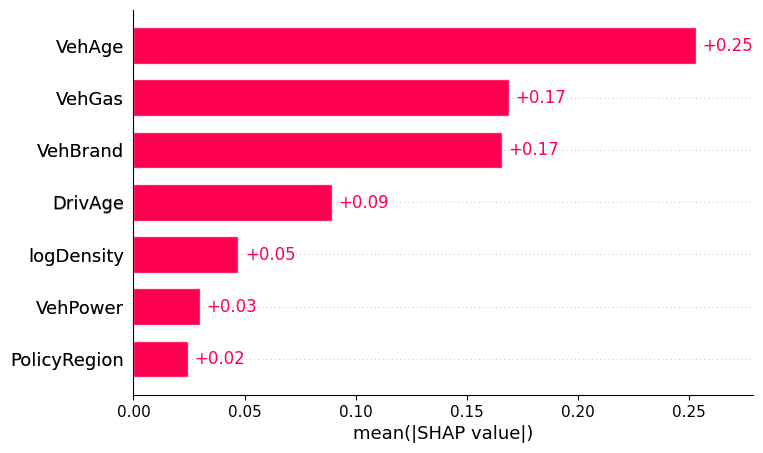

In [ ]:
shap.plots.bar(shap.Explanation(values=shap_glm, feature_names=X_explain.columns))

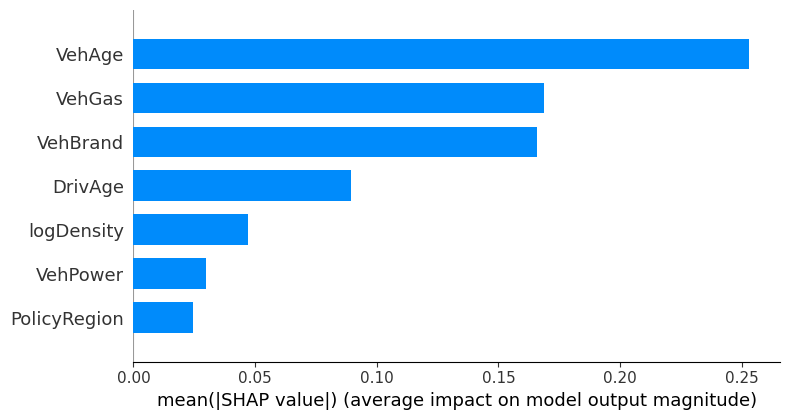

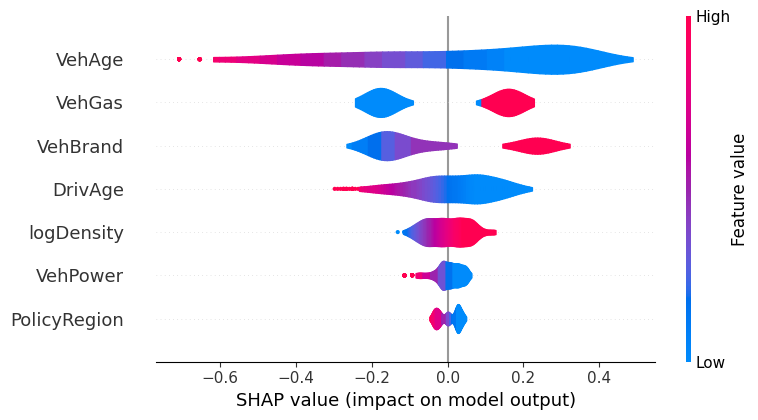

In [ ]:
for t in ("bar", "violin"):
    shap.summary_plot(shap_glm, features=X_explain, plot_type=t, title=t)

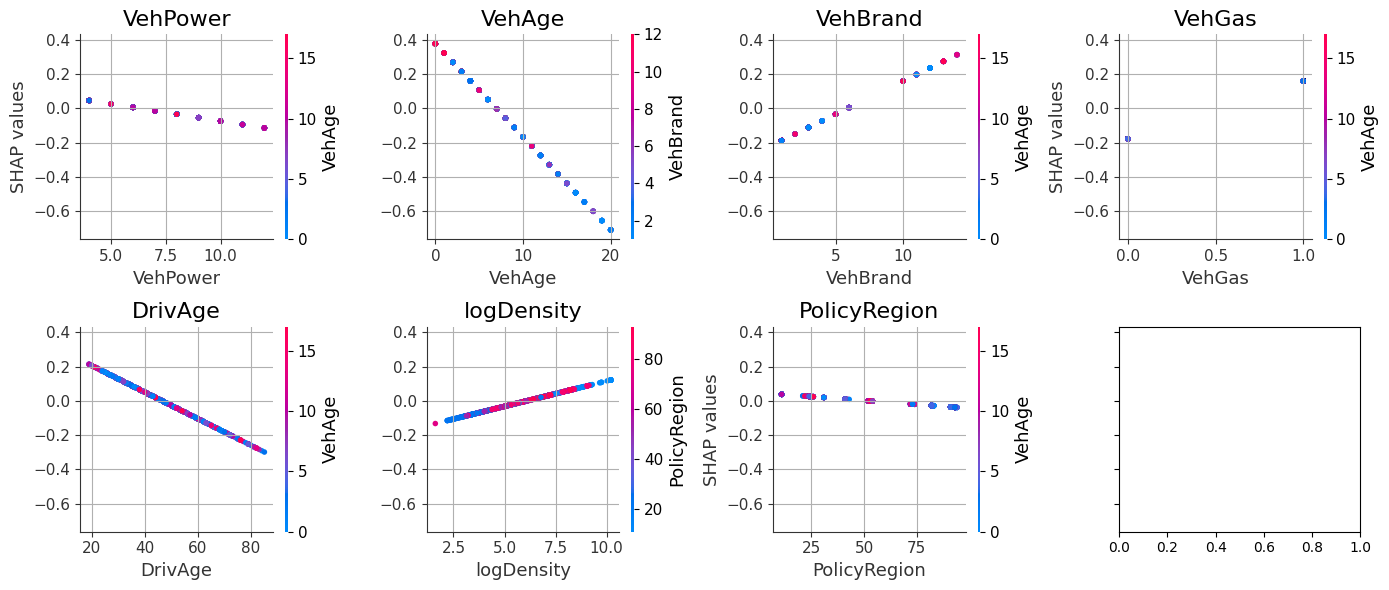

In [ ]:
def all_dep_plots(x, shap_values, X):
    """Dependence plots for all features x."""
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 6), sharey=True)

    for i, ax in enumerate(axes.flat):
        if i < len(x):
            xvar = x[i]
            shap.dependence_plot(
                xvar,
                shap_values,
                features=X,
                # x_jitter=0.2,
                # ymin=-ymin,
                # ymax=1,
                ax=ax,
                show=False,
            )
            ax.set_title(xvar, fontdict={"size": 16})
            ax.set_ylabel("SHAP values" if i % 3 == 0 else "")
            ax.grid()

    plt.tight_layout()

# Call the modified function with your data
all_dep_plots(x, shap_glm, X_explain)

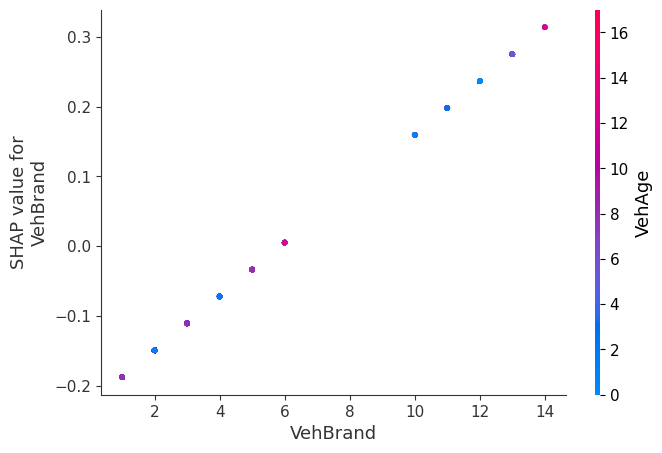

In [ ]:
shap.dependence_plot(2, shap_glm, X_explain)

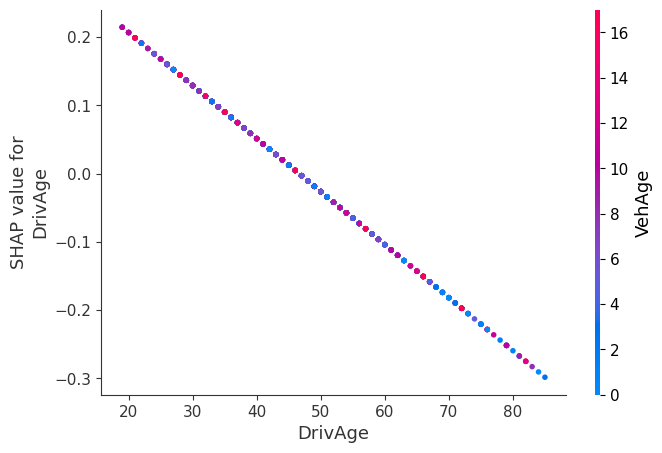

In [ ]:
shap.dependence_plot(4, shap_glm, X_explain)

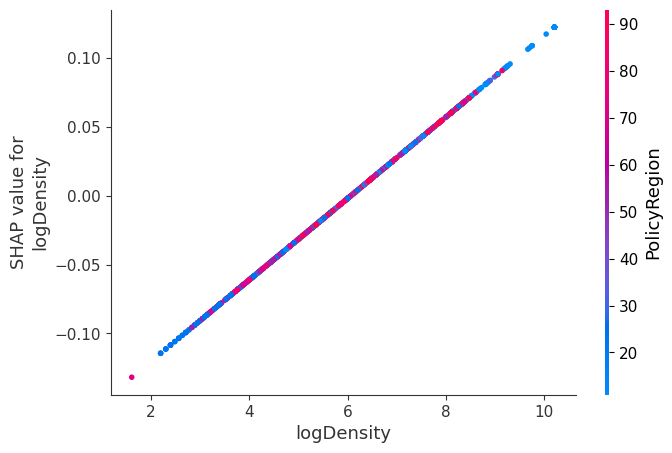

In [ ]:
shap.dependence_plot(5, shap_glm, X_explain)

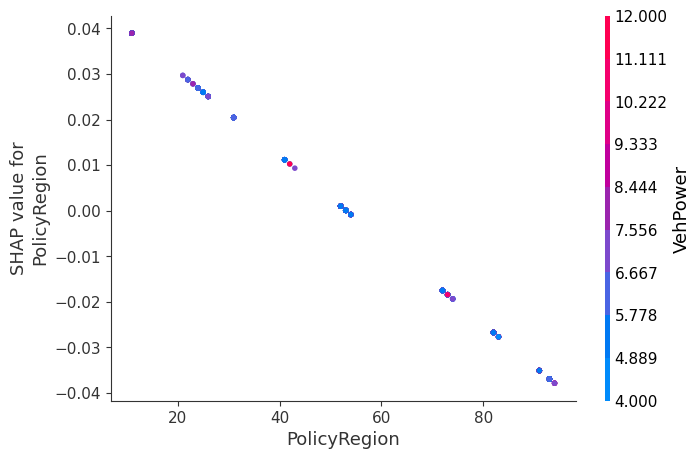

In [ ]:
shap.dependence_plot("PolicyRegion", shap_glm, X_explain, interaction_index="VehPower")